In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fraudulent-transaction-dataset/Fraud.csv
/kaggle/input/fraudulent-transaction-dataset/Data Dictionary.txt


# Steps:

* Objectives
* Data Understanding
* Data Preparation
* Modeling

# Objectives

Build a model to predict fradulent transactions based on the given dataset

# Data Understanding

### About Dataset
step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [30]:
# Importing necessary libraries for understanding data
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [31]:
# Reading the data
data = pd.read_csv('../input/fraudulent-transaction-dataset/Fraud.csv')

In [32]:
# data shape
data.shape

(6362620, 11)

In [33]:
# Top 5 rows
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [34]:
# basic info
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in the dataset.

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


* Target class is 'isFraud' and rest of the columns are features
* Will drop 'nameOrig' and 'nameDest' as we can not make any relationship with fraud and names
* 'type' column to be converted to numeric for processing
* 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest; and 'newbalanceDest' to be normalized for speedy convergence

In [36]:
data[data['amount']==0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


From here, we can say that there are 16 rows with amount of the transcation is zero, this can be seen as an indicator for fraudulent transcations. So, we need to make a indicator feature which indicates whether amount is 0 or not. be remove it.Amount=0 is always associated with CASH_OUT which can be think of as failed withdrawal.(due to no balance or some interrupt).

In [37]:
data.drop(data[data['amount'] == 0].index,axis=0,inplace=True)


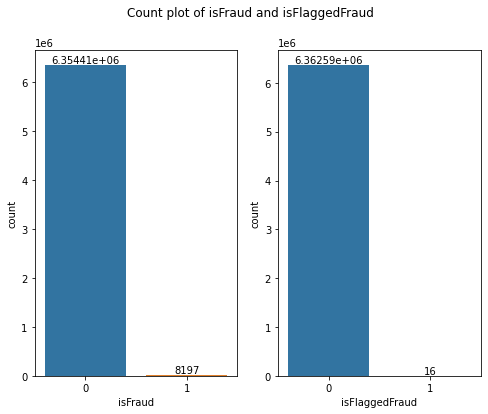

In [38]:
# Target class chart
plt.figure(figsize=(8,6))

plt.subplot(121)
ax = sns.countplot(data=data,x='isFraud')
ax.bar_label(ax.containers[0])

plt.subplot(122)
ax = sns.countplot(data=data,x='isFlaggedFraud')
ax.bar_label(ax.containers[0])

plt.suptitle('Count plot of isFraud and isFlaggedFraud')
plt.show()

* This is an imbalanced dataset
* Seems only 16 transactions labelled as 'isFlaggedFraud'

In [39]:
#isFlaggeddraud transactions
data[data['isFlaggedFraud']==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


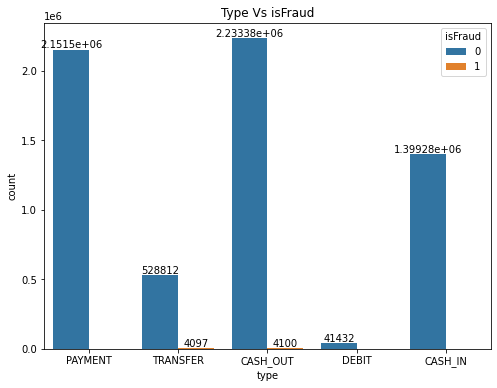

In [40]:
# Countplot of type feature
plt.figure(figsize=(8,6))
ax = sns.countplot(data=data,x='type',hue='isFraud')
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])
plt.title('Type Vs isFraud')
plt.show()

* Transfer and Cash_out transactions are seems fraud
* Only Transfer transactions are made 'isFlaggedFraud'

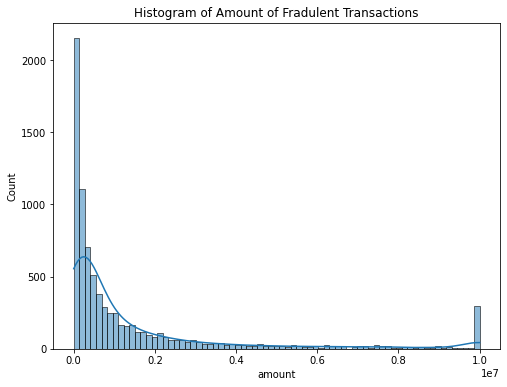

In [41]:
# Histogram of Amount feature based on fraud
plt.figure(figsize=(8,6))
sns.histplot(data=data[data['isFraud']==1],x='amount',kde=True)
plt.title('Histogram of Amount of Fradulent Transactions')
plt.show()

* Distribution is positively skewed
* Most of the transactions lie below amount of 200000

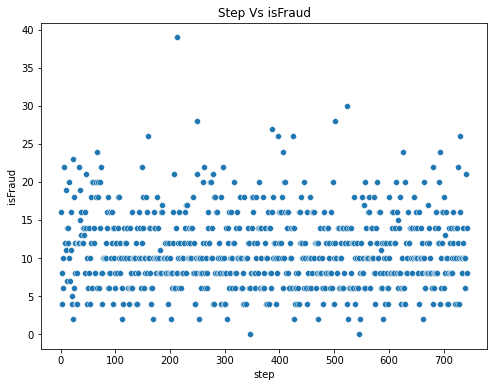

In [42]:
step_group = data.groupby('step').sum().reset_index()
plt.figure(figsize=(8,6))
sns.scatterplot(data=step_group,x='step',y='isFraud')
plt.title('Step Vs isFraud')
plt.show()

* Seems no relationship exists between time and fraudulent transactions

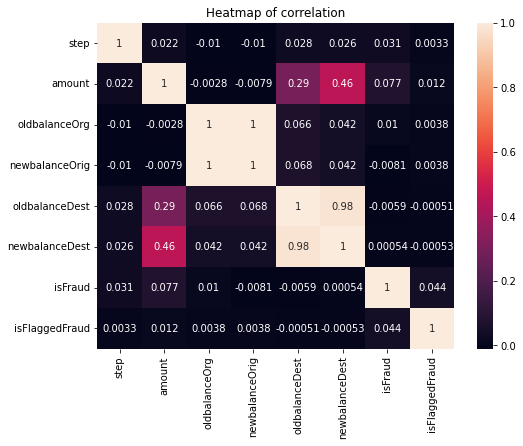

In [43]:
#Heatmap of correlations
plt.figure(figsize=(8,6))
sns.heatmap(data=data.corr(),annot=True)
plt.title('Heatmap of correlation')
plt.show()

Here, we can observe that initial balance before the transaction and new balance after the transaction are highly correlated because new balance = old balance plus or minus amount. So they are lineraly correleated. Multicollinearity can be removed by dropping any of the two columns(i.e old or new)

# Data Preparation

In [44]:
data.drop(data[data['type'] == 'CASH_IN'].index,axis=0,inplace=True)
data.drop(data[data['type'] == 'DEBIT'].index,axis=0,inplace=True)
data.drop(data[data['type'] == 'PAYMENT'].index,axis=0,inplace=True)

From 'Type Vs isFraud', we get there are no fraudulents if type are 'CASH_IN','DEBIT','PAYMENT'. Dropping these these dummies may help us in detecting fraudulents more accuralety as it will reduce class imbalance.

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [46]:
# getting dummies for type feature for conversion
type_dummies = pd.get_dummies(data['type'],prefix='type')

In [47]:
#adding dummies and removing type
data_copy = pd.concat([data.drop('type',axis=1),type_dummies],axis=1)

### Splitting features and target 


In [48]:
X = data_copy.drop(['isFraud','nameOrig','nameDest'],axis=1)
y = data_copy['isFraud']

In [49]:
# Splitting train and test data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y,random_state=1)

* Used stratify, to maintain proportion of target sample as the data

In [50]:
col_to_scale = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
# scaler
scaler = MinMaxScaler().fit(X_train[col_to_scale])
X_train[col_to_scale] = scaler.transform(X_train[col_to_scale])
X_test[col_to_scale] = scaler.transform(X_test[col_to_scale])

# Modeling

> **Decision Tree**

In [51]:
from sklearn import tree
from sklearn.metrics import classification_report

In [52]:
clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(f'Classification Report of XGB Classifier: \n\n{classification_report(y_test,y_pred)}')

Classification Report of XGB Classifier: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828659
           1       0.89      0.86      0.88      2459

    accuracy                           1.00    831118
   macro avg       0.94      0.93      0.94    831118
weighted avg       1.00      1.00      1.00    831118



> **XRB CLASSIFIER**

In [53]:
from xgboost import XGBClassifier

from warnings import simplefilter

simplefilter("ignore")
# XGB Classifier Model
xgbc = XGBClassifier(random_state=1)
# Fitting the model
xgbc.fit(X_train,y_train,eval_set=[[X_train,y_train],[X_test,y_test]])
#predictions on test data
y_pred = xgbc.predict(X_test)
#Classification Report
print(f'Classification Report of XGB Classifier: \n\n{classification_report(y_test,y_pred)}')

[0]	validation_0-logloss:0.43849	validation_1-logloss:0.43850
[1]	validation_0-logloss:0.29774	validation_1-logloss:0.29777
[2]	validation_0-logloss:0.20916	validation_1-logloss:0.20921
[3]	validation_0-logloss:0.14995	validation_1-logloss:0.15001
[4]	validation_0-logloss:0.10901	validation_1-logloss:0.10908
[5]	validation_0-logloss:0.08011	validation_1-logloss:0.08020
[6]	validation_0-logloss:0.05944	validation_1-logloss:0.05953
[7]	validation_0-logloss:0.04444	validation_1-logloss:0.04456
[8]	validation_0-logloss:0.03350	validation_1-logloss:0.03362
[9]	validation_0-logloss:0.02549	validation_1-logloss:0.02563
[10]	validation_0-logloss:0.01949	validation_1-logloss:0.01968
[11]	validation_0-logloss:0.01514	validation_1-logloss:0.01534
[12]	validation_0-logloss:0.01189	validation_1-logloss:0.01210
[13]	validation_0-logloss:0.00949	validation_1-logloss:0.00972
[14]	validation_0-logloss:0.00768	validation_1-logloss:0.00794
[15]	validation_0-logloss:0.00630	validation_1-logloss:0.00657
[1

> XGB Hyperparameter Tuning

In [54]:
from sklearn.metrics import recall_score
import optuna
def run(trial):
#     fold = 0
    learning_rate = trial.suggest_float("learning_rate", 1e-2, 0.25, log=True)
    reg_lambda = trial.suggest_loguniform("reg_lambda", 1e-8, 100.0)
    reg_alpha = trial.suggest_loguniform("reg_alpha", 1e-8, 100.0)
    subsample = trial.suggest_float("subsample", 0.1, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 1.0)
    max_depth = trial.suggest_int("max_depth", 1, 7)

    model = XGBClassifier(
        random_state=42,
        n_estimators=15,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        reg_alpha=reg_alpha,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
    )
    model.fit(X_train, y_train,early_stopping_rounds=300,eval_set=[(X_test, y_test)],eval_metric=['logloss'], verbose=1000)
    preds_valid = model.predict(X_test)
    check_arr =[]
    for i in range(len(preds_valid)):
        check_arr.append(preds_valid[i])
    score = recall_score(y_test,y_pred)
    return score

In [55]:
study = optuna.create_study(direction="minimize")
study.optimize(run, n_trials=30)

[I 2022-05-11 17:12:46,217] A new study created in memory with name: no-name-f2d5fe89-805c-4b25-a153-1ccfc916ea0f


[0]	validation_0-logloss:0.66150
[14]	validation_0-logloss:0.36779


[I 2022-05-11 17:12:55,179] Trial 0 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.03241449943852569, 'reg_lambda': 1.4874832031848515, 'reg_alpha': 95.96820955040272, 'subsample': 0.5695318768166191, 'colsample_bytree': 0.7520341492885271, 'max_depth': 2}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.50491
[14]	validation_0-logloss:0.03052


[I 2022-05-11 17:13:02,127] Trial 1 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.21300452069282064, 'reg_lambda': 0.008992608569027784, 'reg_alpha': 1.2424768453105517, 'subsample': 0.7338528256073129, 'colsample_bytree': 0.20816044686200996, 'max_depth': 2}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.54055
[14]	validation_0-logloss:0.04949


[I 2022-05-11 17:13:08,219] Trial 2 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.16866086349461942, 'reg_lambda': 58.13197527585233, 'reg_alpha': 0.001216835044173456, 'subsample': 0.19952588490829468, 'colsample_bytree': 0.19644197082957277, 'max_depth': 3}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.56450
[14]	validation_0-logloss:0.06744


[I 2022-05-11 17:13:19,083] Trial 3 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.13986021851407002, 'reg_lambda': 5.901267089692391e-07, 'reg_alpha': 3.623107197133671e-05, 'subsample': 0.6901818095463786, 'colsample_bytree': 0.25250713619769694, 'max_depth': 4}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.68302
[14]	validation_0-logloss:0.56046


[I 2022-05-11 17:13:25,474] Trial 4 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.01028249264340368, 'reg_lambda': 2.6339837669739052e-08, 'reg_alpha': 1.132194801285763, 'subsample': 0.8047027492843162, 'colsample_bytree': 0.6022642655766601, 'max_depth': 1}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.65139
[14]	validation_0-logloss:0.30438


[I 2022-05-11 17:13:39,093] Trial 5 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.04288686701985842, 'reg_lambda': 7.047162367193171e-07, 'reg_alpha': 0.28963496233044866, 'subsample': 0.41117349150427285, 'colsample_bytree': 0.5667774250432789, 'max_depth': 5}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67769
[14]	validation_0-logloss:0.50301


[I 2022-05-11 17:13:52,358] Trial 6 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.01574256029666291, 'reg_lambda': 4.168817702702568e-06, 'reg_alpha': 3.695339643047274, 'subsample': 0.8834333764486036, 'colsample_bytree': 0.4370103345228963, 'max_depth': 6}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.66709
[14]	validation_0-logloss:0.40845


[I 2022-05-11 17:14:10,085] Trial 7 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.02664408089571995, 'reg_lambda': 1.803050982660785e-08, 'reg_alpha': 2.9249785499025214e-08, 'subsample': 0.9678191953734484, 'colsample_bytree': 0.4883717318900128, 'max_depth': 6}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.56185
[14]	validation_0-logloss:0.06318


[I 2022-05-11 17:14:24,337] Trial 8 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.14280852013008571, 'reg_lambda': 2.0380744610692125, 'reg_alpha': 1.972198843053842e-08, 'subsample': 0.8230109319360801, 'colsample_bytree': 0.3855803741061623, 'max_depth': 6}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.60688
[14]	validation_0-logloss:0.13920


[I 2022-05-11 17:14:35,829] Trial 9 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.09147473997696944, 'reg_lambda': 4.971334132413552e-05, 'reg_alpha': 9.780995710515566e-07, 'subsample': 0.7783428327422087, 'colsample_bytree': 0.15855650932039328, 'max_depth': 6}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.63530
[14]	validation_0-logloss:0.22760


[I 2022-05-11 17:14:42,935] Trial 10 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.060257484283511485, 'reg_lambda': 0.029316877926005028, 'reg_alpha': 0.00618066362039946, 'subsample': 0.4906975448786761, 'colsample_bytree': 0.911832163524238, 'max_depth': 1}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.66323
[14]	validation_0-logloss:0.37992


[I 2022-05-11 17:14:52,324] Trial 11 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.03060571097819677, 'reg_lambda': 0.06258992385883481, 'reg_alpha': 47.74833037867759, 'subsample': 0.5766166929144974, 'colsample_bytree': 0.7924118999800579, 'max_depth': 2}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.48686
[14]	validation_0-logloss:0.01926


[I 2022-05-11 17:15:01,767] Trial 12 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.23509527979603045, 'reg_lambda': 0.0034734694469052496, 'reg_alpha': 73.93389316076389, 'subsample': 0.3096906539077948, 'colsample_bytree': 0.7217299040396954, 'max_depth': 3}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.62797
[14]	validation_0-logloss:0.19870


[I 2022-05-11 17:15:11,979] Trial 13 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.06799068013070282, 'reg_lambda': 0.7226200808035941, 'reg_alpha': 0.014870609918869893, 'subsample': 0.5952069683204435, 'colsample_bytree': 0.9928126890543201, 'max_depth': 2}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.66596
[14]	validation_0-logloss:0.40014


[I 2022-05-11 17:15:23,342] Trial 14 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.027732854462089875, 'reg_lambda': 0.0007375697013666957, 'reg_alpha': 0.119767637101903, 'subsample': 0.6413132226594681, 'colsample_bytree': 0.7045090821241142, 'max_depth': 3}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.60571
[14]	validation_0-logloss:0.13498


[I 2022-05-11 17:15:30,819] Trial 15 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.0927558460101455, 'reg_lambda': 4.770839532982691, 'reg_alpha': 7.448339521860039, 'subsample': 0.4336744623879959, 'colsample_bytree': 0.35180828082228355, 'max_depth': 2}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.65143
[14]	validation_0-logloss:0.30397


[I 2022-05-11 17:15:44,961] Trial 16 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.04291091285298529, 'reg_lambda': 62.864532045638185, 'reg_alpha': 4.77723179755217e-05, 'subsample': 0.7041650328279986, 'colsample_bytree': 0.8431857096249464, 'max_depth': 4}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67238
[14]	validation_0-logloss:0.45331


[I 2022-05-11 17:15:53,096] Trial 17 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.021117055846096355, 'reg_lambda': 0.00025839626469180795, 'reg_alpha': 0.04233373032995413, 'subsample': 0.11076973785531957, 'colsample_bytree': 0.6498506771939709, 'max_depth': 3}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.61003
[14]	validation_0-logloss:0.14669


[I 2022-05-11 17:15:58,946] Trial 18 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.08795681024937482, 'reg_lambda': 1.7022700591835707, 'reg_alpha': 10.65860087975955, 'subsample': 0.4050094837117336, 'colsample_bytree': 0.3291692589836928, 'max_depth': 1}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.65411
[14]	validation_0-logloss:0.31956


[I 2022-05-11 17:16:11,324] Trial 19 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.04012665245842325, 'reg_lambda': 59.69099724657498, 'reg_alpha': 3.427286154214898e-05, 'subsample': 0.30453713797224413, 'colsample_bytree': 0.8438033532267627, 'max_depth': 4}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67700
[14]	validation_0-logloss:0.49655


[I 2022-05-11 17:16:24,145] Trial 20 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.01635109613763468, 'reg_lambda': 0.00033783402413367435, 'reg_alpha': 0.0565100914939368, 'subsample': 0.1080046886724029, 'colsample_bytree': 0.6419026206093, 'max_depth': 7}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67860
[14]	validation_0-logloss:0.51239


[I 2022-05-11 17:16:30,061] Trial 21 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.014826096968098465, 'reg_lambda': 0.3027845706349816, 'reg_alpha': 9.511586044165592, 'subsample': 0.32573777232021833, 'colsample_bytree': 0.5223740353162025, 'max_depth': 1}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.65748
[14]	validation_0-logloss:0.34102


[I 2022-05-11 17:16:36,348] Trial 22 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.03671778220015594, 'reg_lambda': 13.953074518011684, 'reg_alpha': 4.553010177894781e-05, 'subsample': 0.31359369445765284, 'colsample_bytree': 0.8356963221847414, 'max_depth': 1}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67473
[14]	validation_0-logloss:0.47435


[I 2022-05-11 17:16:52,372] Trial 23 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.01867532540345251, 'reg_lambda': 7.74544289022902e-05, 'reg_alpha': 2.3433221026012917e-06, 'subsample': 0.15399206972376528, 'colsample_bytree': 0.7413667282526747, 'max_depth': 7}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.68269
[14]	validation_0-logloss:0.55629


[I 2022-05-11 17:17:00,983] Trial 24 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.010642367769441257, 'reg_lambda': 0.20265210147357557, 'reg_alpha': 87.63541434561903, 'subsample': 0.2388360021698093, 'colsample_bytree': 0.5071982879901142, 'max_depth': 5}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.68071
[14]	validation_0-logloss:0.53462


[I 2022-05-11 17:17:08,075] Trial 25 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.012649747533996478, 'reg_lambda': 9.59900299519342, 'reg_alpha': 0.0002589669541948797, 'subsample': 0.5026697275485962, 'colsample_bytree': 0.9484411652737456, 'max_depth': 1}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67295
[14]	validation_0-logloss:0.45791


[I 2022-05-11 17:17:28,891] Trial 26 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.020492026259043904, 'reg_lambda': 1.6434957658320285e-05, 'reg_alpha': 7.190691064571478e-07, 'subsample': 0.2004582088183056, 'colsample_bytree': 0.7838148902074262, 'max_depth': 7}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.68272
[14]	validation_0-logloss:0.55694


[I 2022-05-11 17:17:41,401] Trial 27 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.010536222089969106, 'reg_lambda': 0.1263140134302347, 'reg_alpha': 1.1861367857515826e-06, 'subsample': 0.2055692755975202, 'colsample_bytree': 0.6982167368112926, 'max_depth': 5}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.68025
[14]	validation_0-logloss:0.52970


[I 2022-05-11 17:17:59,077] Trial 28 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.01303376586715647, 'reg_lambda': 7.4568854304711865, 'reg_alpha': 0.0005324721902343416, 'subsample': 0.5107677589711194, 'colsample_bytree': 0.9924600974920086, 'max_depth': 5}. Best is trial 0 with value: 0.868239121594144.


[0]	validation_0-logloss:0.67236
[14]	validation_0-logloss:0.45291


[I 2022-05-11 17:18:09,076] Trial 29 finished with value: 0.868239121594144 and parameters: {'learning_rate': 0.021168336152625526, 'reg_lambda': 0.0025371741308923552, 'reg_alpha': 7.665492577238356e-08, 'subsample': 0.5073975633246861, 'colsample_bytree': 0.9325280760609946, 'max_depth': 2}. Best is trial 0 with value: 0.868239121594144.


In [56]:
study.best_params

{'learning_rate': 0.03241449943852569,
 'reg_lambda': 1.4874832031848515,
 'reg_alpha': 95.96820955040272,
 'subsample': 0.5695318768166191,
 'colsample_bytree': 0.7520341492885271,
 'max_depth': 2}

In [57]:
xgbc1 = XGBClassifier(learning_rate = 0.16623808021746095,
 reg_lambda = 2.9221946715731066e-08,
 reg_alpha = 0.04763024864262888,
 subsample = 0.19825029541462386,
 colsample_bytree = 0.8050047032894155,
 max_depth = 6)
# Fitting the model
xgbc.fit(X_train,y_train,eval_set=[[X_train,y_train],[X_test,y_test]])
#predictions on test data
y_pred = xgbc.predict(X_test)
#Classification Report
print(f'Classification Report of XGB Classifier: \n\n{classification_report(y_test,y_pred)}')

[0]	validation_0-logloss:0.43849	validation_1-logloss:0.43850
[1]	validation_0-logloss:0.29774	validation_1-logloss:0.29777
[2]	validation_0-logloss:0.20916	validation_1-logloss:0.20921
[3]	validation_0-logloss:0.14995	validation_1-logloss:0.15001
[4]	validation_0-logloss:0.10901	validation_1-logloss:0.10908
[5]	validation_0-logloss:0.08011	validation_1-logloss:0.08020
[6]	validation_0-logloss:0.05944	validation_1-logloss:0.05953
[7]	validation_0-logloss:0.04444	validation_1-logloss:0.04456
[8]	validation_0-logloss:0.03350	validation_1-logloss:0.03362
[9]	validation_0-logloss:0.02549	validation_1-logloss:0.02563
[10]	validation_0-logloss:0.01949	validation_1-logloss:0.01968
[11]	validation_0-logloss:0.01514	validation_1-logloss:0.01534
[12]	validation_0-logloss:0.01189	validation_1-logloss:0.01210
[13]	validation_0-logloss:0.00949	validation_1-logloss:0.00972
[14]	validation_0-logloss:0.00768	validation_1-logloss:0.00794
[15]	validation_0-logloss:0.00630	validation_1-logloss:0.00657
[1

# Explanation

I have chosen the recall as my evaluation metrics because recall is important for us as it tell us the percentage of positive instances out of the total actual positive instances. Therefore denominator (TP + FN) here is the actual number of positive instances present in the dataset.

Recall = TruePositives / (TruePositives + FalseNegatives)

A recall of 0.87 means that 87% of item from class "isFraud=1" was labelled as belonging to class "isFraud=1" in actual data.

So,XGB Classifer is best preffered to detect fraudulents.

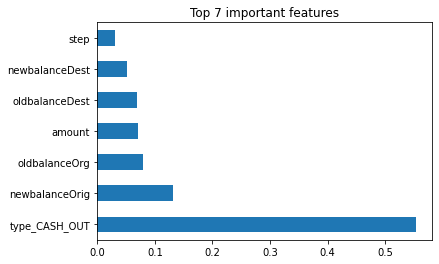

In [58]:
feat_importances = pd.Series(xgbc.feature_importances_, index= X.columns)
feat_importances.nlargest(7).plot(kind='barh')
plt.title("Top 7 important features")
plt.show()

From feature importance graph, we can conclude that "type" feature have a larger effect on the model that is being used to predict fraudulent transactions which is further confirmed from the 'Type Vs isFraud' graph as type 'CASH_OUT' and type 'Transfer' contains fraud transcations.

****ASSIGMENT SOLUTIONS****

Ans-1
* There are no missing values in the dataset.
* We can say that there are 16 rows with amount of the transcation is zero, this can be seen as an indicator for fraudulent transcations. So, we need to make a indicator feature which indicates whether amount is 0 or not. be remove it.Amount=0 is always associated with CASH_OUT which can be think of as failed withdrawal(due to no balance or some interrupt).
* Here, we can observe that initial balance before the transaction and new balance after the transaction are highly correlated because new balance = old balance plus or minus amount. So they are lineraly correleated. Multicollinearity can be removed by dropping any of the two columns(i.e old or new)

Ans-2
* We have use XGBoost Classifier whose hyperparameters are tuned by optuna.

Ans-3
* From feature importance graph, we can conclude that "type" feature have a larger effect on the model that is being used to predict fraudulent transactions which is further confirmed from the 'Type Vs isFraud' graph as type 'CASH_OUT' and type 'Transfer' contains fraud transcations.So, from feature graph and corelation plot, I selected variables to be included in the model.

Ans-4
* I have chosen the recall as my evaluation metrics because recall is important for us as it tell us the percentage of positive instances out of the total actual positive instances. Therefore denominator (TP + FN) here is the actual number of positive instances present in the dataset.

  Recall = TruePositives / (TruePositives + FalseNegatives)

  A recall of 0.87 means that 87% of item from class "isFraud=1" was labelled as belonging to class "isFraud=1" in actual data.

  So,XGB Classifer is best preffered to detect fraudulents as per recall score.

Ans-5
* Type_CASH_OUT feature which represents type of transcation is found to be the most important factors by feature importance graph. Further balance before the transaction and after the transaction are key factors that predict fraudulent customer. Amount,initial balance recipient before the trancation and new balance recipient after the transaction are also the important features.

Ans-6
* Cash_out is the important factor because a certain type is more prone to frauds as it has less security. As fraudelents want more money, so they always try to attack customer with higher intial balance.

Ans-7
* Only Transfer and Cash_out transactions seems to have fraudent transcations.So, company should try to increase the securities in cash_out and transfer sections. Company should aware all the customers about the safety and securities to decrease fraudulent transcations. Company website should add a new feature for customers to report fraudelent activity.

Ans-8
* Assuming these actions have been implemented, we will get the reports of fraudelent activity which determines that prevetions would have worked.